In [21]:
from linares_plot import *
import statsmodels.formula.api as smf


In [2]:
data = pd.read_csv('C:\\Users\\David\\Dropbox\\IDIBAPS\\my code\\Project 1 (master thesis)\\idibaps_psychophysics')

In [8]:
data.type.unique()

array([0., 4., 1., 3., 2.])

In [9]:
df_controls = data.loc[data['type']==0]
df_controls.head()

,Unnamed: 0,r_T,r_NT,delay,type,A_T,A_NT,A_err,r_err,A_R,r_R,subject,session,Int_A_err,Int_r_err
0,0,13.68,NaN,0.0,0.0,314.0,NaN,-1.90,1.81,315.90,11.87,1,1,NaN,NaN
2,2,10.70,NaN,3.0,0.0,50.0,NaN,6.38,2.97,43.62,7.73,1,1,NaN,NaN
5,5,13.68,NaN,0.0,0.0,129.0,NaN,-10.73,0.62,139.73,13.06,1,1,NaN,NaN
6,6,13.68,NaN,3.0,0.0,304.0,NaN,4.01,0.96,299.99,12.72,1,1,NaN,NaN
7,7,13.68,NaN,3.0,0.0,215.0,NaN,-1.36,-1.49,216.36,15.17,1,1,NaN,NaN


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


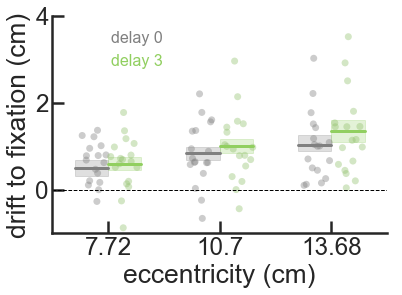

In [37]:
c_d0='grey'
c_d3 = '#91cf60'
df_controls['delay_n']=df_controls['delay'].copy()
df_controls['delay_n']=df_controls['delay_n'].replace([0,3], ['delay 0', 'delay 3'])


linares_plot(x='r_T', y='r_err', hue='delay_n', order=[7.72, 10.7, 13.68], hue_order=['delay 0','delay 3'],
             alpha=0.4, palette=[c_d0, c_d3], df=df_controls, point_size=7,   CI=0.68,
             by_subj=True, subj_col='subject',
             plot_box=True, fill_box=True, reps=100, alpha_box=0.25, sep_axis=False)
plt.ylim(-1,4)

plt.xlabel('eccentricity (cm)')
plt.ylabel('drift to fixation (cm)')
plt.plot([-1,3], [0,0], 'k--', linewidth=1);


In [38]:
res_m = smf.mixedlm(formula='r_err ~ r_T * delay', data=df_controls, groups=df_controls['subject']).fit()
print(res_m.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: r_err     
No. Observations: 3396    Method:             REML      
No. Groups:       18      Scale:              0.9515    
Min. group size:  72      Likelihood:         -4786.2985
Max. group size:  239     Converged:          Yes       
Mean group size:  188.7                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.163    0.198 -0.823 0.410 -0.550  0.225
r_T            0.088    0.010  9.072 0.000  0.069  0.107
delay         -0.078    0.050 -1.554 0.120 -0.177  0.020
r_T:delay      0.013    0.005  2.865 0.004  0.004  0.022
Group Var      0.497    0.177                           



In [ ]:
dfr=data.loc[(data['type']==3) | (data['type']==4)]

in_out=[]
### in --> the target is closer to fixation
### out --> the target is far from fixation

for i in dfr.index:
    if dfr.loc[i, 'r_T']<dfr.loc[i, 'r_NT']:
        in_out.append('in')
    else:
        in_out.append('out')


dfr['in_out'] = in_out


print(len(dfr))

def mod(target,report,radius_t, radius_r):
    #units given in degrees and cm
    y_t=np.array(radius_t*np.sin(np.radians(target)),dtype=np.float)
    x_t=np.array(radius_t*np.cos(np.radians(target)),dtype=np.float)
    y_r=np.array(radius_r*np.sin(np.radians(report)),dtype=np.float)
    x_r=np.array(radius_r*np.cos(np.radians(report)),dtype=np.float)
    m = np.sqrt((x_t - x_r)**2 + (y_t - y_r)**2)
    return m


modules = [round(mod(dfr.loc[i,'A_T'], dfr.loc[i,'A_R'], dfr.loc[i,'r_T'], dfr.loc[i,'r_R']),3) for i in dfr.index]
dfr['modules']=modules


from pandas import concat
frames=[]
for group_label in dfr.subject.unique():
    sub_group=dfr.groupby('subject').get_group(group_label)
    #CI
    #interval = sub_group.quantile([0.025, 0.975]).unstack(level=1)['A_err']
    #removed_out = sub_group.loc[(sub_group['A_err']>interval.iloc[0]) & (sub_group['A_err']<interval.iloc[1])] 
    #
    #Quartiles
    limit=sub_group['modules'].mean() + 2*sub_group['modules'].std()
    #print(round(limit,2))
    removed_out =sub_group.loc[sub_group['modules']<limit  ]
    
    
    frames.append(removed_out)
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(removed_out)
    print( 'Outliers in ' + str(group_label) + ' = ' +str(before_outliers-after_outliers) + ', limit=' +str(round(limit,2))  + 'cm')
    


dfr = concat(frames)
print(len(dfr))

### Distribution A_Err in cw-ccw
sns.distplot(dfr.loc[ dfr['r_T']==7.72, 'r_R'], color='b', label='7.72')
sns.distplot(dfr.loc[ dfr['r_T']==10.7, 'r_R'], color='g', label='10.7')
sns.distplot(dfr.loc[ dfr['r_T']==13.68, 'r_R'], color='r', label='13.68')
plt.title('Distribution radial response')
plt.legend(frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.xlabel('radial response')

plt.plot([7.72, 7.72], [0, 0.4], 'k--')
plt.plot([10.7, 10.7], [0, 0.4], 'k--')
plt.plot([13.68, 13.68], [0, 0.4], 'k--')
plt.show()

sns.pointplot(x='r_T', y='r_err', hue='delay', x_estimator=np.mean, legend=False, data=dfr)
plt.legend(frameon=False)
plt.title('Drift to fixation')
plt.xlabel('Radius target')
plt.ylabel('Attraction fixation (cm)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.show()



dfr['drift_norm'] = dfr['r_err']  / dfr['r_T']
sns.pointplot(x='r_T', y='drift_norm', hue='delay', x_estimator=np.mean, legend=False, data=dfr)
plt.legend(frameon=False)
plt.title('Drift to fixation normalized')
plt.xlabel('Radius target')
plt.ylabel('Attraction fixation (cm)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()
plt.show()